In [ ]:
import numpy as np
import pandas as pd
import os

dataset_dir = 'C:/Users/srujan/DDOS_AI/03-11/'

print("Available CSV files:")
for filename in os.listdir(dataset_dir):
    if filename.endswith('.csv'):
        print(os.path.join(dataset_dir, filename))

Available CSV files:
C:/Users/srujan/DDOS_AI/03-11/LDAP.csv
C:/Users/srujan/DDOS_AI/03-11/MSSQL.csv
C:/Users/srujan/DDOS_AI/03-11/NetBIOS.csv
C:/Users/srujan/DDOS_AI/03-11/Portmap.csv
C:/Users/srujan/DDOS_AI/03-11/Syn.csv
C:/Users/srujan/DDOS_AI/03-11/UDP.csv
C:/Users/srujan/DDOS_AI/03-11/UDPLag.csv


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
class DDoSAnalysis:
    def __init__(self, file_path):
        self.raw_data = pd.read_csv(file_path, low_memory=False)
        self.processed_data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def lightweight_eda(self):
        print("Dataset Shape:", self.raw_data.shape)
        print("\nColumns:", list(self.raw_data.columns))
        print("\nData Types:\n", self.raw_data.dtypes)
        print("\nColumns with Missing Values:", self.raw_data.columns[self.raw_data.isnull().any()])

        if ' Label' in self.raw_data.columns:
            plt.figure(figsize=(8, 8))
            self.raw_data[' Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
            plt.title('Label Distribution')
            plt.ylabel('')
            plt.tight_layout()
            plt.show()
        else:
            print("Target Column 'Label' Missing.")

    def preprocess_data(self, target_column=' Label', test_size=0.2):
        df = self.raw_data.copy()

        categorical_cols = df.select_dtypes(include=['object']).columns
        label_encoder = LabelEncoder()
        for col in categorical_cols:
            df[col] = label_encoder.fit_transform(df[col].astype(str))

        df = df.drop(['Timestamp'], axis=1, errors='ignore')

        X = df.drop(columns=[target_column])
        y = df[target_column]

        if X.isnull().any().any() or np.isinf(X.values).any():
            print("Warning: NaN or Infinite values detected in the feature set. Handling them.")
            X = X.fillna(X.mean())
            X = X.replace([np.inf, -np.inf], X.max().max())
            X = X.clip(lower=-1e6, upper=1e6)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

        self.processed_data = df

    def feature_importance(self, n_features=10):
        selector = SelectKBest(score_func=f_classif, k=n_features)
        X_new = selector.fit_transform(self.X_train, self.y_train)

        feature_names = self.processed_data.drop(columns=[' Label']).columns
        selected_features = feature_names[selector.get_support()]

        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(self.X_train, self.y_train)

        feature_imp = pd.DataFrame({
            'feature': selected_features,
            'importance': rf_classifier.feature_importances_[:len(selected_features)]
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_imp)
        plt.title(f'Top {n_features} Most Important Features')
        plt.tight_layout()
        plt.show()

        return feature_imp

    def train_ml_models(self):
        models = {
            'SVM': {
                'model': SVC(),
                'params': {
                    'C': [0.1, 1, 10],
                    'kernel': ['linear', 'rbf']
                }
            },
            'Random Forest': {
                'model': RandomForestClassifier(),
                'params': {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [None, 10, 20, 30]
                }
            },
            'XGBoost': {
                'model': XGBClassifier(),
                'params': {
                    'learning_rate': [0.01, 0.1, 0.5],
                    'n_estimators': [50, 100, 200]
                }
            }
        }

        results = {}
        for name, setup in models.items():
            grid_search = GridSearchCV(
                estimator=setup['model'], 
                param_grid=setup['params'], 
                cv=5, 
                scoring='f1', 
                n_jobs=-1
            )

            grid_search.fit(self.X_train, self.y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(self.X_test)

            results[name] = {
                'best_params': grid_search.best_params_,
                'classification_report': classification_report(self.y_test, y_pred),
                'confusion_matrix': confusion_matrix(self.y_test, y_pred),
                'accuracy': accuracy_score(self.y_test, y_pred)
            }

        return results

    def deep_learning_model(self):
        X_train = self.X_train
        X_test = self.X_test
        y_train = tf.keras.utils.to_categorical(self.y_train)
        y_test = tf.keras.utils.to_categorical(self.y_test)

        def create_model(learning_rate=0.001, units1=64, units2=32, dropout_rate=0.3):
            model = Sequential([
                Dense(units1, activation='relu', input_shape=(X_train.shape[1],)),
                BatchNormalization(),
                Dropout(dropout_rate),
                Dense(units2, activation='relu'),
                BatchNormalization(),
                Dropout(dropout_rate),
                Dense(y_train.shape[1], activation='softmax')
            ])

            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, 
                          loss='categorical_crossentropy', 
                          metrics=['accuracy'])
            return model

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

        model = create_model()
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        return {
            'classification_report': classification_report(y_test_classes, y_pred_classes),
            'confusion_matrix': confusion_matrix(y_test_classes, y_pred_classes),
            'accuracy': accuracy_score(y_test_classes, y_pred_classes)
        }

In [20]:
# Initialize with your Syn.csv file
ddos_analysis = DDoSAnalysis("C:/Users/srujan/DDOS_AI/03-11/Syn.csv")


Performing light weight EDA...
Dataset Shape: (4320541, 88)

Columns: ['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Pack

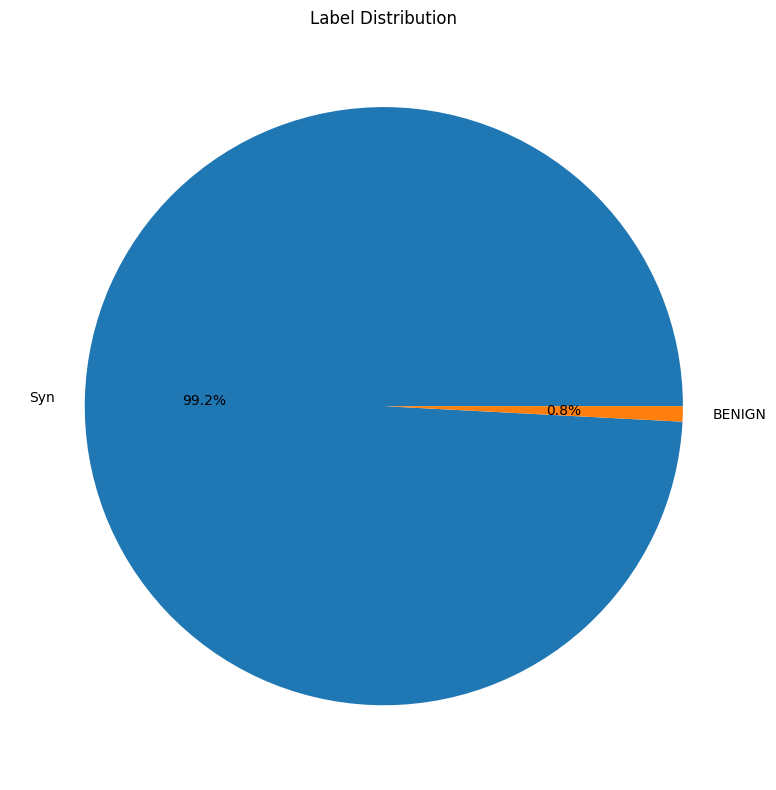

In [21]:
# Perform EDA
print("Performing light weight EDA...")
ddos_analysis.lightweight_eda()

In [22]:
# Preprocess Data
print("\nPreprocessing Data...")
ddos_analysis.preprocess_data()


Preprocessing Data...


C:\Users\srujan\AppData\Local\Temp\ipykernel_3396\3487144438.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mean(), inplace=True)
C:\Users\srujan\AppData\Local\Temp\ipykernel_3396\3487144438.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example


Feature Importance Analysis...


c:\Users\srujan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [38 39 40 50 53 57 63 64 65 66 67 68] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\srujan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


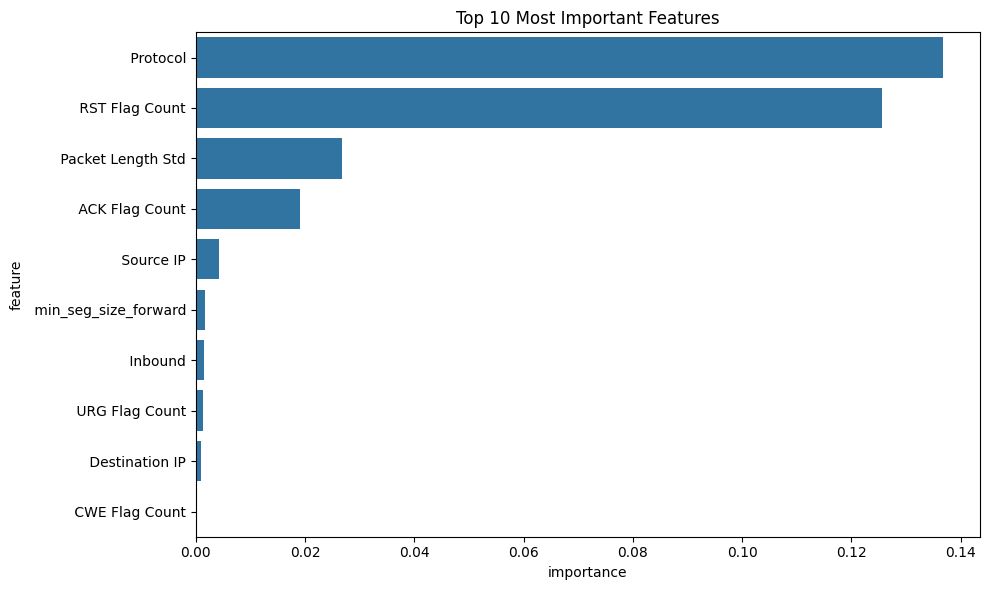

,feature,importance
2,Protocol,0.136695
4,RST Flag Count,0.125645
3,Packet Length Std,0.026806
5,ACK Flag Count,0.019046
0,Source IP,0.004178
8,min_seg_size_forward,0.001633
9,Inbound,0.001534
6,URG Flag Count,0.001389
1,Destination IP,0.000886
7,CWE Flag Count,0.000010


In [23]:
# Feature Importance
print("\nFeature Importance Analysis...")
ddos_analysis.feature_importance()

In [26]:
ml_results = ddos_analysis.train_ml_models(use_sample=True)  # ← Uses 10% data for tuning

c:\Users\srujan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:29:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\srujan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:29:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\srujan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:29:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\srujan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:29:51] WARNING: C:\a

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

results_list = []

for model_name, model_results in ml_results.items():
    results_list.append({
        'Model': model_name,
        'Best Parameters': model_results['best_params'],
        'Accuracy': model_results['accuracy'],
        'Confusion Matrix': model_results['confusion_matrix']
    })

results_df = pd.DataFrame(results_list)

print("Model Performance Summary:")
print(results_df)

for model_name, model_results in ml_results.items():
    print(f"\n{model_name} Classification Report:")
    print(model_results['classification_report'])
    print("-" * 50)

for model_name, model_results in ml_results.items():
    print(f"\n{model_name} Confusion Matrix:")
    print(pd.DataFrame(model_results['confusion_matrix'], columns=['Predicted 0', 'Predicted 1'], 
                       index=['Actual 0', 'Actual 1']))
    print("-" * 50)


Model Performance Summary:
           Model                             Best Parameters  Accuracy  \
0            SVM                   {'C': 1, 'kernel': 'rbf'}  0.999912   
1  Random Forest    {'max_depth': None, 'n_estimators': 100}  0.999985   
2        XGBoost  {'learning_rate': 0.1, 'n_estimators': 50}  0.999991   

            Confusion Matrix  
0  [[7156, 2], [74, 856877]]  
1  [[7158, 0], [13, 856938]]  
2   [[7156, 2], [6, 856945]]  

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7158
           1       1.00      1.00      1.00    856951

    accuracy                           1.00    864109
   macro avg       0.99      1.00      1.00    864109
weighted avg       1.00      1.00      1.00    864109

--------------------------------------------------

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7158


Training Deep Learning Model...


c:\Users\srujan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27004/27004 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step


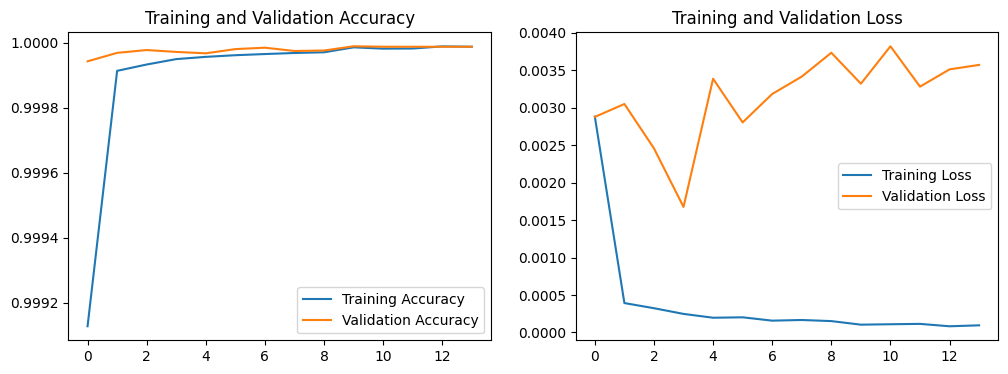

{'classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      7158\n           1       1.00      1.00      1.00    856951\n\n    accuracy                           1.00    864109\n   macro avg       1.00      1.00      1.00    864109\nweighted avg       1.00      1.00      1.00    864109\n', 'confusion_matrix': array([[  7148,     10],
       [    12, 856939]], dtype=int64), 'accuracy': 0.9999745402489733}


In [ ]:
print("\nTraining Deep Learning Model...")
dl_results = ddos_analysis.deep_learning_model()
print(dl_results)

In [29]:
results_list = []

results_list.append({
    'Model': 'Deep Learning Model',
    'Accuracy': dl_results['accuracy'],
    'Confusion Matrix': dl_results['confusion_matrix']
})

results_df = pd.DataFrame(results_list)

print("Model Performance Summary:")
print(results_df)

print("\nDeep Learning Model Classification Report:")
print(dl_results['classification_report'])
print("-" * 50)

print("\nDeep Learning Model Confusion Matrix:")
conf_matrix = dl_results['confusion_matrix']
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], 
                              index=['Actual 0', 'Actual 1'])
print(conf_matrix_df)
print("-" * 50)

Model Performance Summary:
                 Model  Accuracy            Confusion Matrix
0  Deep Learning Model  0.999975  [[7148, 10], [12, 856939]]

Deep Learning Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7158
           1       1.00      1.00      1.00    856951

    accuracy                           1.00    864109
   macro avg       1.00      1.00      1.00    864109
weighted avg       1.00      1.00      1.00    864109

--------------------------------------------------

Deep Learning Model Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         7148           10
Actual 1           12       856939
--------------------------------------------------


In [ ]:
import joblib

best_rf_model = ml_results['Random Forest']['best_params']
final_model = RandomForestClassifier(**best_rf_model)
final_model.fit(ddos_analysis.X_train, ddos_analysis.y_train)

joblib.dump(final_model, 'ddos_model.pkl')
joblib.dump(StandardScaler().fit(ddos_analysis.X_train), 'ddos_scaler.pkl')

['ddos_scaler.pkl']